# Ejemplo de Entrenamiento
---

En este ejemplo vamos a usar Pytorch para entrenar un modelo definido por nosotros con datos descargados de la librería Torchvision.

---

## 1. Instalar e importar las librerías necesarias

En este ejemplo vamos a trabajar con Pytorch y los datos de Torchvision

In [ ]:
! pip install torchinfo

In [ ]:
import torch
print(torch.__version__)

2.1.0+cu121


In [ ]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
from torchinfo import summary

Inicializamos con una semilla los generadores de números aleatorios, para hacer replicables los resultados:

In [ ]:
theSEED = 232323
torch.manual_seed(theSEED)
np.random.seed(theSEED)
random.seed(theSEED)

Definimos las transformaciones que aplicaremos sobre los datos del dataset y lo descargamos con la librería Torchvision. En nuestro caso, para entrenamiento, aleatoriamente vamos a calcular la imagen espejo sobre el eje horizontal, luego una rotación aleatoria de hasta 15º y, por último, normalizamos los valores en el rango [0, 1]. Para test, simplemente normalizamos los valores en el rango [0, 1].

## 2. Definir el modelo

Definiremos un modelo muy simple con una capa Flatten (para convertir la imagen, con forma de matriz, en un array unidimensional) y dos capas Dense, o Fully-Connected.

In [ ]:
input_shape = 32 * 32 * 3

class DenseModel(torch.nn.Module):

    def __init__(self):
        super(DenseModel, self).__init__()

        self.linear1 = torch.nn.Linear(input_shape, 512)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(512, 10)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

model = DenseModel()
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
DenseModel                               [1, 10]                   --
├─Linear: 1-1                            [1, 512]                  1,573,376
├─ReLU: 1-2                              [1, 512]                  --
├─Linear: 1-3                            [1, 10]                   5,130
├─Softmax: 1-4                           [1, 10]                   --
Total params: 1,578,506
Trainable params: 1,578,506
Non-trainable params: 0
Total mult-adds (M): 1.58
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 6.31
Estimated Total Size (MB): 6.33

## 3. Descargar la base de datos

Vamos a trabajar con la base de datos CIFAR10 que está disponible en Torchvision. Esta base de datos está compuesta por 60.000 imágenes a color de 32x32 pixels y 10 classes, con 6.000 imágenes por clase. Simplemente definimos las transformaciones que aplicaremos a los datos e instanciamos los conjuntos de train y test. La librería automáticamente descarga los datos y define el objecto dataset de Pytorch.

In [ ]:
# Transformaciones
transform_train = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomRotation(15),
        torchvision.transforms.ToTensor()
    ])
transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

# Conjuntos de datos
cifar10_train = torchvision.datasets.CIFAR10(root='./cifar10', train=True, transform=transform_train, download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10', train=False, transform=transform_test, download=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 105082201.73it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


Vamos a visualizar una de las muestras y la clase a la que pertenece:

Etiqueta:  9


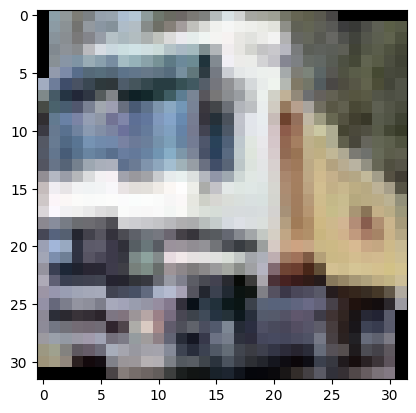

In [ ]:
x_train, y_train = cifar10_train.__getitem__(1)
plt.imshow(x_train.permute(1, 2, 0))
print("Etiqueta: ", y_train)

## 4. Definir los data loader

Una vez descargados los datos, tenemos que crear un DataLoader de Pytorch para poder usarlos con nuestro modelo. En este caso, particionamos los datos de entrenamiento en dos subconjuntos: train y val, para poder analizar el rendimiento del modelo durante el entrenamiento.

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

train_indices, val_indices = train_test_split(np.arange(len(cifar10_train.targets)), test_size=0.2, shuffle=True, stratify=cifar10_train.targets)

cifar10_train_train = Subset(cifar10_train, train_indices)
cifar10_train_val = Subset(cifar10_train, val_indices)

train_data_loader = torch.utils.data.DataLoader(cifar10_train_train, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_data_loader = torch.utils.data.DataLoader(cifar10_train_val, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 5. Entrenamiento del modelo

Realizamos unas épocas para hacer que los pesos del modelo se adapten para clasificar las imágenes de entrada. Para ello, para cada batch, hacemos una inferencia del modelo para obtener su comportamiento y luego calculamos el error con respecto a la salida esperada. Para ello, usamos la base de datos que hemos descargado en el punto 3. Además, como función de loss usamos la Crossentropy Loss cuya ecuación es la siguiente:

Loss = $-\sum_{c=1}^My_{o,c}\log(p_{o,c})$

In [ ]:
n_epochs = 10
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
model.cuda()
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(n_epochs): # Entrenamos n epocas
    # Entrenamiento
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    train_counter = 0
    time_start = time.time()
    for inputs, labels in train_data_loader: # Obtenemos todos los batch de entrenamiento y los usamos para entrenar
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        opt.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        train_counter = train_counter + 1
        loss.backward()
        opt.step()

    train_epoch_loss = train_running_loss / train_counter
    train_epoch_acc = 100. * (train_running_correct / len(train_data_loader.dataset))
    train_time_end = time.time() - time_start

    # Validacion
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    val_counter = 0
    time_start = time.time()
    for inputs, labels in val_data_loader: # Obtenemos todos los batch de entrenamiento y los usamos para entrenar
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        with torch.no_grad():
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
        val_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        val_running_correct += (preds == labels).sum().item()
        val_counter = val_counter + 1

    val_epoch_loss = val_running_loss / val_counter
    val_epoch_acc = 100. * (val_running_correct / len(val_data_loader.dataset))
    val_time_end = time.time() - time_start

    train_losses.append(train_epoch_loss)
    train_accs.append(train_epoch_acc)
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)

    print(f'** Summary for epoch {epoch}: '
		f'[train_loss: {train_epoch_loss:#.3g}, train_acc: {train_epoch_acc:#.3g} '
		f'train_time: {train_time_end:.3f}s] -- '
    f'[val_loss: {val_epoch_loss:#.3g}, val_acc: {val_epoch_acc:#.3g} '
		f'val_time: {val_time_end:.3f}s] **'
    )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


** Summary for epoch 0: [train_loss: 2.20, train_acc: 25.2 train_time: 12.693s] -- [val_loss: 2.15, val_acc: 30.4 val_time: 2.778s] **
** Summary for epoch 1: [train_loss: 2.12, train_acc: 32.9 train_time: 12.435s] -- [val_loss: 2.12, val_acc: 33.5 val_time: 2.854s] **
** Summary for epoch 2: [train_loss: 2.10, train_acc: 34.9 train_time: 12.362s] -- [val_loss: 2.12, val_acc: 33.1 val_time: 3.270s] **
** Summary for epoch 3: [train_loss: 2.09, train_acc: 36.6 train_time: 11.774s] -- [val_loss: 2.08, val_acc: 37.3 val_time: 4.223s] **
** Summary for epoch 4: [train_loss: 2.08, train_acc: 37.2 train_time: 14.397s] -- [val_loss: 2.08, val_acc: 37.4 val_time: 5.187s] **
** Summary for epoch 5: [train_loss: 2.07, train_acc: 38.5 train_time: 20.048s] -- [val_loss: 2.08, val_acc: 37.3 val_time: 5.042s] **
** Summary for epoch 6: [train_loss: 2.06, train_acc: 39.3 train_time: 13.410s] -- [val_loss: 2.07, val_acc: 38.3 val_time: 2.852s] **
** Summary for epoch 7: [train_loss: 2.06, train_acc: 3

A continuación, vamos a pintar unas gráficas con los valores de loss y acc para entrenamiento y validación y poder analizar el comportamiento del modelo:

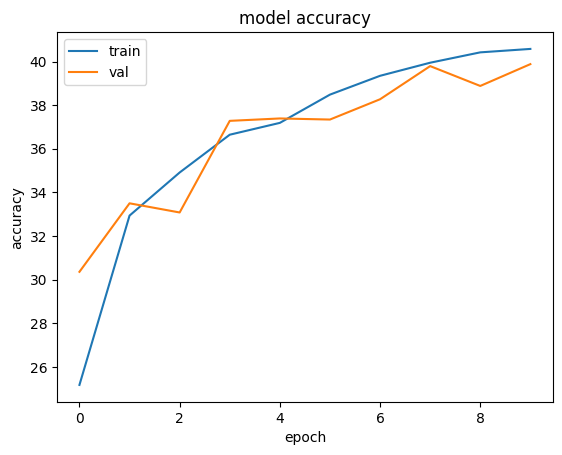

In [ ]:
# summarize history for accuracy
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

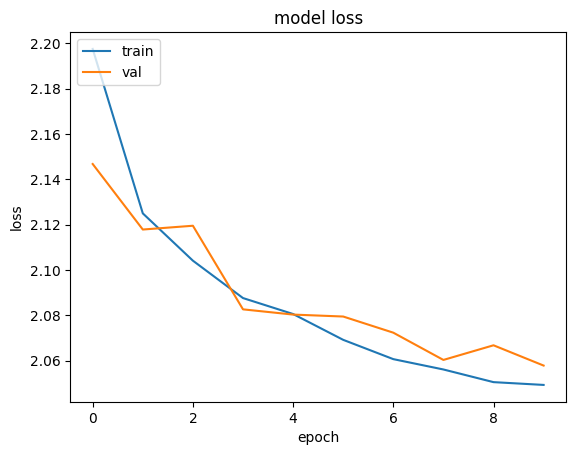

In [ ]:
# summarize history for loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Con el conjunto de test, evaluamos el modelo entrenado:

In [ ]:
# Test
model.eval()
test_correct = 0
time_start = time.time()
for inputs, labels in test_data_loader: # Obtenemos todos los batch de entrenamiento y los usamos para entrenar
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')

    with torch.no_grad():
        outputs = model(inputs)

    _, preds = torch.max(outputs.data, 1)
    test_correct += (preds == labels).sum().item()

test_epoch_acc = 100. * (test_correct / len(test_data_loader.dataset))
test_time_end = time.time() - time_start

print(f'** Summary: '
f'[test_acc: {test_epoch_acc:#.3g} '
f'test_time: {test_time_end:.3f}s] **'
)

** Summary: [test_acc: 41.0 test_time: 2.589s] **


## 6. Exportar el modelo

Una vez que hemos realizado el entrenamiento, exportamos el modelo a un fichero para poder usarlo posteriormente.

In [ ]:
!mkdir -p './models'

In [ ]:
OUT_MODEL_PATH= './models'
torch.save(model.state_dict(), os.path.join(OUT_MODEL_PATH, 'model-final-1.pt'))